# Zipline backtest and pyfolio tear sheet with `futures_pair_trading.py` algo

This notebook shows how to run a futures backtest in Zipline using the QuantRocket client then analyze the backtests results inside the notebook using pyfolio.

The algo is a pairs trading algo using crude oil and gasoline futures. It is adapted from the Quantopian futures tutorial.

## Step 1: Collect Historical Data (skip if you already have data)
First, let's collect historical data for the backtest. (Typically you might use the command line to perform these steps, but they can also be performed using the Python client, and we show them here to make the notebook more self-contained.) 

The first step is to fetch the listings for CL and RB. This retrieves all the individual contracts from IB for the underlying symbols.

In [2]:
from quantrocket.master import fetch_listings
fetch_listings(exchange="NYMEX", sec_types=["FUT"], symbols=["CL", "RB"])

{'status': 'the listing details will be fetched asynchronously'}

Monitor flightlog for the listings to be fetched, then make a universe:

In [3]:
from quantrocket.master import download_master_file, create_universe
import io

# Download the listings we just fetched
f = io.StringIO()
download_master_file(f, exchanges=["NYMEX"], sec_types=["FUT"], symbols=["CL", "RB"])
# then create a universe
create_universe("cl-rb", infilepath_or_buffer=f)

{'code': 'cl-rb', 'inserted': 155, 'provided': 155, 'total_after_insert': 155}

Now create a history database and fetch the data:

In [4]:
from quantrocket.history import create_db, fetch_history
create_db("cl-rb-1d", universes=["cl-rb"], bar_size="1 day")

{'status': 'successfully created quantrocket.history.cl-rb-1d.sqlite'}

In [5]:
fetch_history("cl-rb-1d")

{'status': 'the historical data will be fetched asynchronously'}

Monitor flightlog for the historical data to be fetched, then move on to the next step, ingesting the data into Zipline.

## Step 2: Ingest Historical Data into Zipline
Next we ingest our history database into Zipline. The historical data for each individual contract is ingested, then Zipline will represent the contracts as continuous futures contracts at the time we run our backtest. 

In [1]:
from quantrocket.zipline import ingest_bundle
ingest_bundle(history_db="cl-rb-1d", calendar="us_futures")

{'msg': 'successfully ingested cl-rb-1d bundle', 'status': 'success'}

## Step 3: Run the Algo

Next, run the backtest. We'll run the `futures_pairs_trading.py` example file from the Zipline repository, which is included in QuantRocket's [codeload-demo GitHub repo](https://github.com/quantrocket-llc/codeload-demo/tree/master/zipline). 

QuantRocket returns the Zipline backtest results as a CSV. We write this CSV to a file.

(Note that the backtest runs remotely on the zipline service, not inside the jupyter service, i.e. not in the notebook environment itself. QuantRocket's jupyter service doesn't support running Zipline backtests via the `%%zipline` extension.)

In [2]:
from quantrocket.zipline import run_algorithm
run_algorithm("futures_pairs_trading.py", 
              bundle="cl-rb-1d",
              start="2015-02-04", 
              end="2017-06-30",
              filepath_or_buffer="futures_pair_trading_results.csv")

## Step 4: Create Tear Sheet

We can easily get a pyfolio tear sheet:

In [3]:
import pyfolio as pf

/opt/conda/lib/python3.6/site-packages/empyrical/utils.py:32: UserWarning: Unable to import pandas_datareader. Suppressing import error and continuing. All data reading functionality will raise errors; but has been deprecated and will be removed in a later version.
  warnings.warn(msg)


Start date,2015-02-05
End date,2017-06-30
Total months,28
,Backtest
Annual return,0.3%
Cumulative returns,0.6%
Annual volatility,7.4%
Sharpe ratio,0.07
Calmar ratio,0.03
Stability,0.08
Max drawdown,-7.6%


/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.58,2016-03-31,2017-04-18,NaT,NaN
1,5.70,2015-03-02,2015-12-18,2016-02-01,241
2,2.41,2016-02-02,2016-02-08,2016-02-25,18
3,1.63,2016-02-25,2016-02-26,2016-03-16,15
4,0.04,2016-03-17,2016-03-18,2016-03-24,6


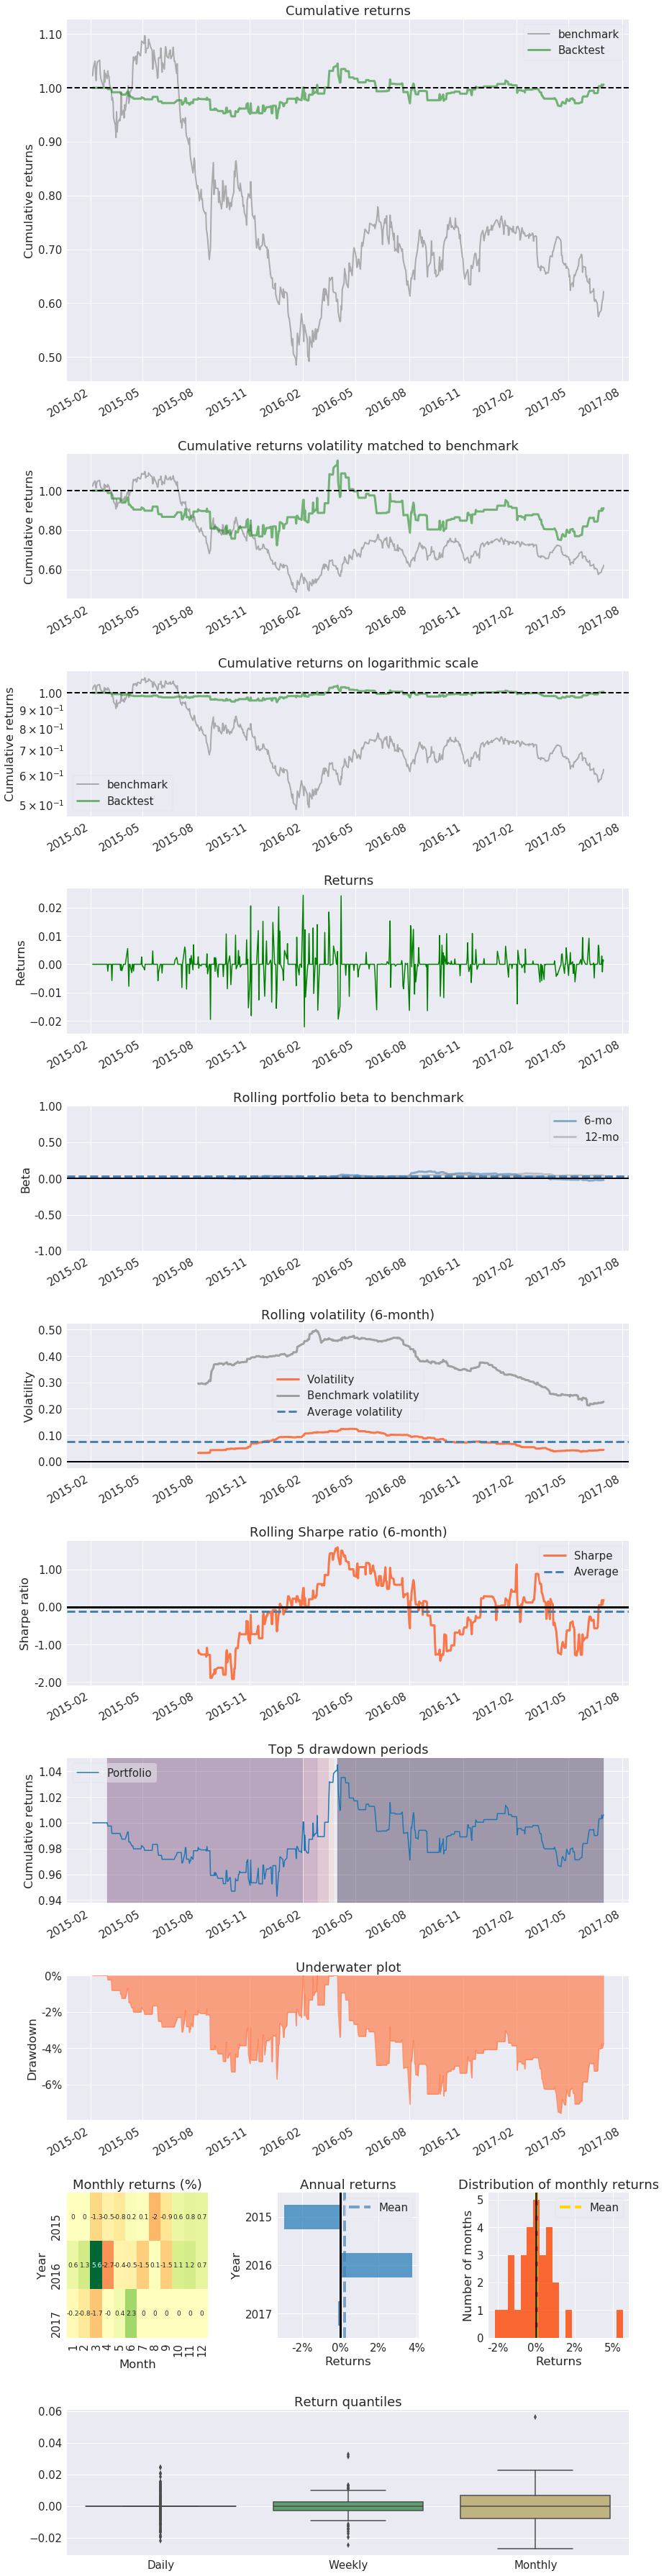

Stress Events,mean,min,max
Fall2015,-0.09%,-1.96%,1.08%
New Normal,0.00%,-2.22%,2.45%


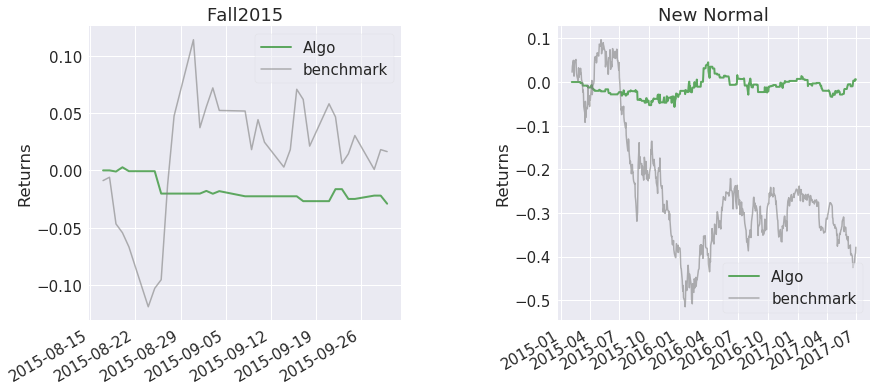

Top 10 long positions of all time,max
column,
Future(43635385 [CLZ5-201512]),0.06%
Future(47207307 [CLM6-201606]),0.05%
Future(55928744 [CLZ7-201712]),0.05%
Future(47207310 [CLZ6-201612]),0.05%
Future(123513564 [RBH6-201603]),0.00%
Future(135678174 [RBV6-201610]),0.00%
Future(121687393 [RBG6-201602]),0.00%
Future(133925537 [RBU6-201609]),0.00%
Future(119783831 [RBF6-201601]),0.00%


Top 10 short positions of all time,max
column,
Future(47207307 [CLM6-201606]),-0.05%
Future(47207310 [CLZ6-201612]),-0.05%
Future(55928744 [CLZ7-201712]),-0.05%
Future(43635385 [CLZ5-201512]),-0.05%
Future(119783831 [RBF6-201601]),-0.00%
Future(116588449 [RBX5-201511]),-0.00%
Future(123513564 [RBH6-201603]),-0.00%
Future(158931144 [RBN7-201707]),-0.00%
Future(153402292 [RBM7-201706]),-0.00%


Top 10 positions of all time,max
column,
Future(43635385 [CLZ5-201512]),0.06%
Future(47207307 [CLM6-201606]),0.05%
Future(47207310 [CLZ6-201612]),0.05%
Future(55928744 [CLZ7-201712]),0.05%
Future(123513564 [RBH6-201603]),0.00%
Future(135678174 [RBV6-201610]),0.00%
Future(121687393 [RBG6-201602]),0.00%
Future(119783831 [RBF6-201601]),0.00%
Future(133925537 [RBU6-201609]),0.00%


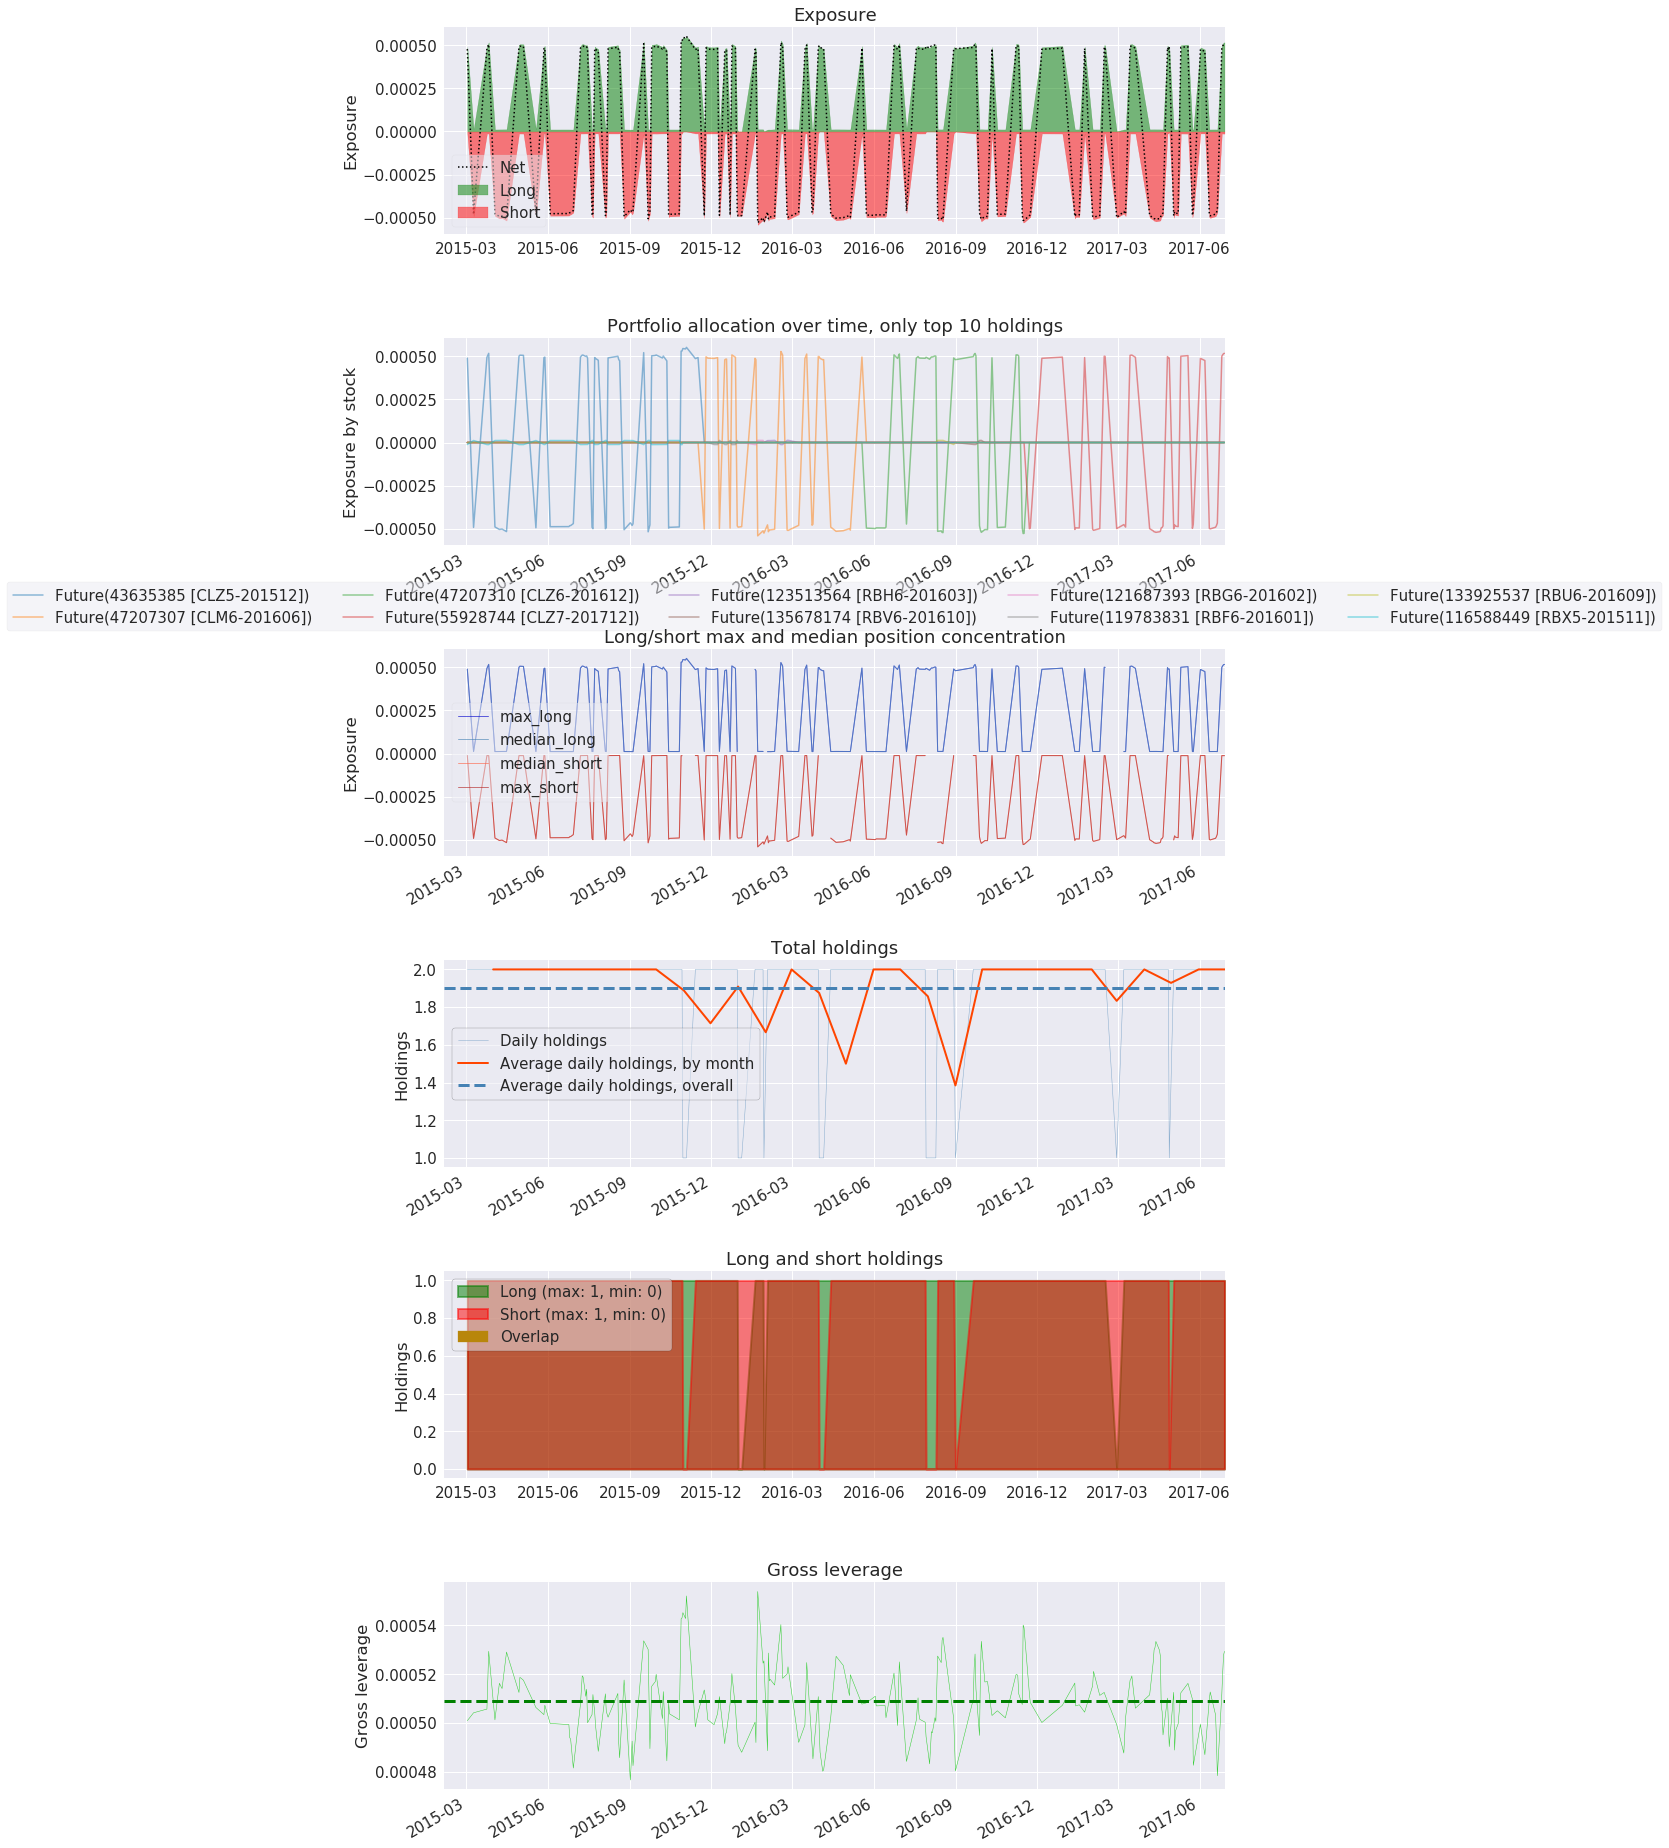

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


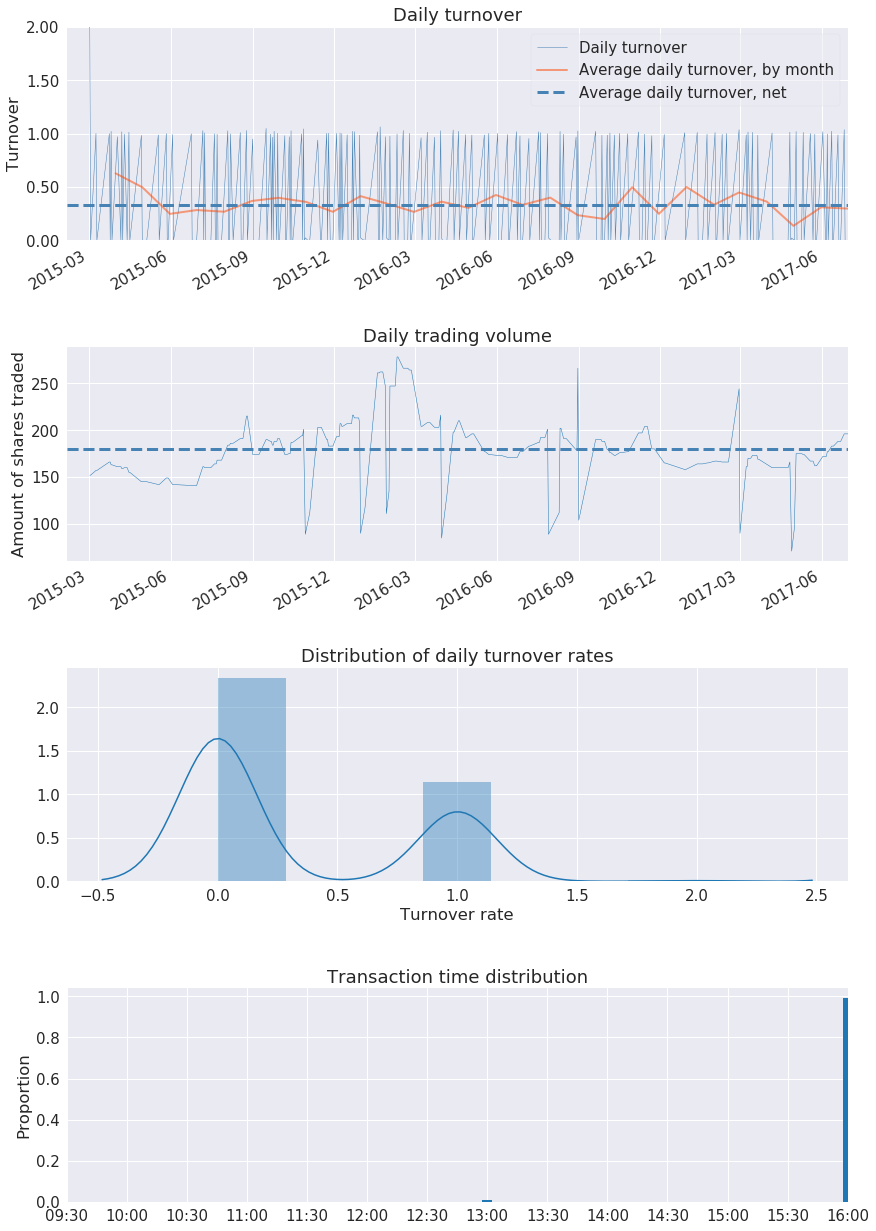

In [4]:
pf.from_zipline_csv("futures_pair_trading_results.csv")

## Analyze your backtest results  

The CSV result file returned by `run_algorithm` contains several DataFrames stacked into one: the Zipline performance results, plus the extracted returns, transactions, positions, and benchmark returns from those results. If you want to explore the Zipline backtest results directly, you can use the `ZiplineBacktestResult` utility class to parse the CSV and look at the `perf` DataFrame: 

In [5]:
from quantrocket.zipline import ZiplineBacktestResult
zipline_results = ZiplineBacktestResult.from_csv("futures_pair_trading_results.csv")
print(zipline_results.perf.head())

column                     Crude_Oil  Gasoline  algorithm_period_return  \
date                                                                      
2015-02-04 00:00:00+00:00      58.00    66.024                      0.0   
2015-02-05 00:00:00+00:00      59.31    67.830                      0.0   
2015-02-06 00:00:00+00:00      60.11    69.216                      0.0   
2015-02-09 00:00:00+00:00      60.88    70.350                      0.0   
2015-02-10 00:00:00+00:00      59.56    69.048                      0.0   

column                     benchmark_period_return  capital_used  ending_cash  \
date                                                                            
2015-02-04 00:00:00+00:00                -0.041524           0.0   10000000.0   
2015-02-05 00:00:00+00:00                -0.019876           0.0   10000000.0   
2015-02-06 00:00:00+00:00                -0.006583           0.0   10000000.0   
2015-02-09 00:00:00+00:00                 0.006077           0.0   10